In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import math
import seaborn as sns
import matplotlib.dates as mdates

# Carregar os dados do arquivo Data.csv
EV = pd.read_csv("Data_merged.csv", sep=";")
#print(EV)

# Convert strings to float
EV['Duration (min)'] = EV['Duration (min)'].str.replace(',', '.').astype(float)
EV['Total Energy (kWh)'] = EV['Total Energy (kWh)'].str.replace(',', '.').astype(float)
EV['Temp'] = EV['Temp'].str.replace(',', '.').str.replace(',', '.').astype(float)
EV['Plus'] = EV['Plus'].str.replace(',', '.').str.replace(',', '.').astype(float)
EV['Start date'] = pd.to_datetime(EV['Start date'], format='%m/%d/%Y | %H:%M')
EV['Stop date'] = pd.to_datetime(EV['Stop date'], format='%m/%d/%Y | %H:%M')


#Remover as linhas com "Total Energy (kWh)" inferior a 1
EV = EV[EV['Total Energy (kWh)'] >= 1].reset_index(drop=True)

#Calcular Power 
EV['Power']= EV['Total Energy (kWh)'] / (EV['Duration (min)']/ 60)


# Crie uma nova coluna 'Period of Day' com base na hora
EV['Period of Day'] = pd.cut(EV['Start date'].dt.hour, bins=[0, 12, 18, 24], labels=['Manhã', 'Tarde', 'Noite'])
# Adicione a coluna 'Day of Week'
EV['Day of Week'] = EV['Start date'].dt.day_name()
# Crie uma nova coluna 'Season' com base no mês (usando o hemisfério norte como referência)
EV['Month'] = EV['Start date'].dt.month
EV['Season'] = EV['Month'].apply(lambda x: 'Inverno' if x in [1, 2, 12] else ('Primavera' if x in [3, 4, 5] else ('Verão' if x in [6, 7, 8] else 'Outono')))
# Crie uma nova coluna 'Período Escolar' com base no mês
EV['Período Escolar'] = EV['Month'].apply(lambda x: 'Férias' if x in [7, 8] else 'Período Escolar')


# Mapeando categorias para números
period_of_day_mapping = {'Manhã': 1, 'Tarde': 2, 'Noite': 3}
day_of_week_mapping = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
season_mapping = {'Inverno': 1, 'Primavera': 2, 'Verão': 3, 'Outono': 4}
periodo_escolar_mapping = {'Férias': 1, 'Período Escolar': 2}
charging_station = {'CAP_SON_MAI_00001': 1, 'CAP_SON_MAI_00002': 2, 'CAP_SON_MAI_00004': 3, 'CAP_SON_MAI_00010': 4, 'CAP_SON_MAI_00003': 5 }


EV['Period of Day'] = EV['Period of Day'].map(period_of_day_mapping)
EV['Day of Week'] = EV['Day of Week'].map(day_of_week_mapping)
EV['Season'] = EV['Season'].map(season_mapping)
EV['Período Escolar'] = EV['Período Escolar'].map(periodo_escolar_mapping)
EV['Charging Station'] = EV['Charging Station'].map(charging_station)


EV = EV[['Start date', 'Stop date', 'Duration (min)','Total Energy (kWh)','Power','Period of Day', 'Day of Week', 'Season', 'Período Escolar', 'Charging Station','Month','Temp','Plus']]
print(EV)

             Start date           Stop date  Duration (min)  \
0   2022-06-07 13:52:00 2022-06-07 17:36:00         224.517   
1   2022-06-15 18:51:00 2022-06-15 18:57:00           6.167   
2   2022-06-15 15:08:00 2022-06-15 15:51:00          43.467   
3   2022-06-15 18:37:00 2022-06-15 18:49:00          12.100   
4   2022-07-19 15:23:00 2022-07-19 20:50:00         327.283   
..                  ...                 ...             ...   
96  2023-05-08 08:38:00 2023-05-08 12:58:00         260.017   
97  2023-05-24 18:42:00 2023-05-24 19:17:00          35.300   
98  2023-05-26 18:51:00 2023-05-26 19:13:00          22.550   
99  2023-05-30 09:32:00 2023-05-30 13:29:00         237.100   
100 2023-05-31 13:46:00 2023-05-31 19:08:00         321.983   

     Total Energy (kWh)      Power Period of Day  Day of Week  Season  \
0                40.190  10.740389             2            2       3   
1                 3.480  33.857629             2            3       3   
2                41.180 

In [2]:
# Group by the 'Start date' and sum the relevant columns
summed_days = EV.groupby(EV['Start date'].dt.date).agg({
    'Duration (min)': 'sum',
    'Total Energy (kWh)': 'sum',
    'Power': 'sum',
    'Temp': 'mean',  # You might want to use 'mean' or 'max' depending on your preference
    'Plus': 'sum',
}).reset_index()

# Convert 'Start date' column to datetime format
summed_days['Start date'] = pd.to_datetime(summed_days['Start date'])

print(summed_days)

   Start date  Duration (min)  Total Energy (kWh)       Power   Temp  Plus
0  2022-06-07         224.517              40.190   10.740389  18.25  0.00
1  2022-06-15          61.734              59.000  161.808190  21.50  0.00
2  2022-07-19         327.283              30.419    5.576642  20.00  0.05
3  2022-07-20          42.883              45.870  129.696141  20.25  0.00
4  2022-08-01         410.717              40.610    5.932552  23.75  0.00
..        ...             ...                 ...         ...    ...   ...
76 2023-05-08         260.017              47.330   10.921594  20.00  0.03
77 2023-05-24          35.300              25.980   44.158640  17.00  0.00
78 2023-05-26          22.550              28.570   76.017738  18.00  0.00
79 2023-05-30         237.100              45.130   11.420498  17.00  0.00
80 2023-05-31         321.983              19.200    3.577829  18.00  0.00

[81 rows x 6 columns]


In [3]:
# Create a DataFrame with all unique days within the date range
all_days = pd.DataFrame({'Start date': pd.date_range(start=EV['Start date'].min().date(), end=EV['Start date'].max().date())})

# Merge the all_days DataFrame with your existing DataFrame
merged_data = pd.merge(all_days, summed_days, on='Start date', how='left')

# Fill NaN values with 0 for columns related to charging sessions
merged_data[['Duration (min)', 'Total Energy (kWh)', 'Power', 'Temp', 'Plus']] = merged_data[
    ['Duration (min)', 'Total Energy (kWh)', 'Power', 'Temp', 'Plus']
].fillna(0)

# Identify rows where there were no charging sessions and set all related columns to zero
merged_data.loc[merged_data['Duration (min)'].isnull(), ['Duration (min)', 'Total Energy (kWh)', 'Power', 'Temp', 'Plus']] = 0

print(merged_data)

    Start date  Duration (min)  Total Energy (kWh)      Power   Temp  Plus
0   2022-06-07         224.517               40.19  10.740389  18.25   0.0
1   2022-06-08           0.000                0.00   0.000000   0.00   0.0
2   2022-06-09           0.000                0.00   0.000000   0.00   0.0
3   2022-06-10           0.000                0.00   0.000000   0.00   0.0
4   2022-06-11           0.000                0.00   0.000000   0.00   0.0
..         ...             ...                 ...        ...    ...   ...
354 2023-05-27           0.000                0.00   0.000000   0.00   0.0
355 2023-05-28           0.000                0.00   0.000000   0.00   0.0
356 2023-05-29           0.000                0.00   0.000000   0.00   0.0
357 2023-05-30         237.100               45.13  11.420498  17.00   0.0
358 2023-05-31         321.983               19.20   3.577829  18.00   0.0

[359 rows x 6 columns]


In [4]:
# Crie uma nova coluna 'Period of Day' com base na hora
#merged_data['Period of Day'] = pd.cut(merged_data['Start date'].dt.hour, bins=[0, 12, 18, 24], labels=['Manhã', 'Tarde', 'Noite'])
# Adicione a coluna 'Day of Week'
merged_data['Day of Week'] = merged_data['Start date'].dt.day_name()
# Crie uma nova coluna 'Season' com base no mês (usando o hemisfério norte como referência)
merged_data['Month'] = merged_data['Start date'].dt.month
merged_data['Season'] = merged_data['Month'].apply(lambda x: 'Inverno' if x in [1, 2, 12] else ('Primavera' if x in [3, 4, 5] else ('Verão' if x in [6, 7, 8] else 'Outono')))
# Crie uma nova coluna 'Período Escolar' com base no mês
merged_data['Período Escolar'] = merged_data['Month'].apply(lambda x: 'Férias' if x in [7, 8] else 'Período Escolar')


# Mapeando categorias para números
#period_of_day_mapping = {'Manhã': 1, 'Tarde': 2, 'Noite': 3}
day_of_week_mapping = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
season_mapping = {'Inverno': 1, 'Primavera': 2, 'Verão': 3, 'Outono': 4}
periodo_escolar_mapping = {'Férias': 1, 'Período Escolar': 2}
#charging_station = {'CAP_SON_MAI_00001': 1, 'CAP_SON_MAI_00002': 2, 'CAP_SON_MAI_00004': 3, 'CAP_SON_MAI_00010': 4, 'CAP_SON_MAI_00003': 5 }


#merged_data['Period of Day'] = merged_data['Period of Day'].map(period_of_day_mapping)
merged_data['Day of Week'] = merged_data['Day of Week'].map(day_of_week_mapping)
merged_data['Season'] = merged_data['Season'].map(season_mapping)
merged_data['Período Escolar'] = merged_data['Período Escolar'].map(periodo_escolar_mapping)
#merged_data['Charging Station'] = merged_data['Charging Station'].map(charging_station)

print(merged_data)

merged_data.to_csv('merged_data2.csv', index=False)

"""# Criar duas novas colunas para representar os valores de energia total nos dias anteriores
merged_data['Total_Energy_Day_before_1'] = merged_data['Total Energy (kWh)'].shift(1)
merged_data['Total_Energy_Day_before_2'] = merged_data['Total Energy (kWh)'].shift(2)

# Remover as linhas com valores NaN resultantes do deslocamento
merged_data = merged_data.dropna()
print(merged_data)
"""

    Start date  Duration (min)  Total Energy (kWh)      Power   Temp  Plus  \
0   2022-06-07         224.517               40.19  10.740389  18.25   0.0   
1   2022-06-08           0.000                0.00   0.000000   0.00   0.0   
2   2022-06-09           0.000                0.00   0.000000   0.00   0.0   
3   2022-06-10           0.000                0.00   0.000000   0.00   0.0   
4   2022-06-11           0.000                0.00   0.000000   0.00   0.0   
..         ...             ...                 ...        ...    ...   ...   
354 2023-05-27           0.000                0.00   0.000000   0.00   0.0   
355 2023-05-28           0.000                0.00   0.000000   0.00   0.0   
356 2023-05-29           0.000                0.00   0.000000   0.00   0.0   
357 2023-05-30         237.100               45.13  11.420498  17.00   0.0   
358 2023-05-31         321.983               19.20   3.577829  18.00   0.0   

     Day of Week  Month  Season  Período Escolar  
0           

"# Criar duas novas colunas para representar os valores de energia total nos dias anteriores\nmerged_data['Total_Energy_Day_before_1'] = merged_data['Total Energy (kWh)'].shift(1)\nmerged_data['Total_Energy_Day_before_2'] = merged_data['Total Energy (kWh)'].shift(2)\n\n# Remover as linhas com valores NaN resultantes do deslocamento\nmerged_data = merged_data.dropna()\nprint(merged_data)\n"

In [49]:
print(summed_days)

# Criar novas colunas para representar os valores de energia total nos 10 dias anteriores
for i in range(1, 11):
    summed_days[f'Total_Energy_Day_before_{i}'] = summed_days['Total Energy (kWh)'].shift(i)


# Criar duas novas colunas para representar os valores de energia total nos dias anteriores
#summed_days['Total_Energy_Day_before_1'] = summed_days['Total Energy (kWh)'].shift(1)
#summed_days['Total_Energy_Day_before_2'] = summed_days['Total Energy (kWh)'].shift(2)

# Remover as linhas com valores NaN resultantes do deslocamento
summed_days = summed_days.dropna()
print(summed_days)

   Start date  Duration (min)  Total Energy (kWh)      Power   Temp  Plus  \
4  2022-08-01         410.717               40.61   5.932552  23.75  0.00   
5  2022-08-03         335.567               36.51   6.528056  22.00  0.00   
6  2022-08-05         309.433               40.99   7.948086  20.50  0.05   
7  2022-08-17         558.300               41.17   4.424503  18.50  0.03   
8  2022-08-22         168.917               32.42  11.515715  21.50  0.00   
..        ...             ...                 ...        ...    ...   ...   
76 2023-05-08         260.017               47.33  10.921594  20.00  0.03   
77 2023-05-24          35.300               25.98  44.158640  17.00  0.00   
78 2023-05-26          22.550               28.57  76.017738  18.00  0.00   
79 2023-05-30         237.100               45.13  11.420498  17.00  0.00   
80 2023-05-31         321.983               19.20   3.577829  18.00  0.00   

    Total_Energy_Day_before_1  Total_Energy_Day_before_2  
4               

Temp: 0.10248077270881965
Plus: 0.034591228528002504
Total_Energy_Day_before_1: 0.08019102337732378
Total_Energy_Day_before_2: 0.044555916331580785
Total_Energy_Day_before_3: 0.0667958668386089
Total_Energy_Day_before_4: 0.22639404384719333
Total_Energy_Day_before_5: 0.009404520875855195
Total_Energy_Day_before_6: 0.06187083824269436
Total_Energy_Day_before_7: 0.14618483353764813
Total_Energy_Day_before_8: 0.02751910923030343
Total_Energy_Day_before_9: 0.11036436749444933
Total_Energy_Day_before_10: 0.08964747898752046


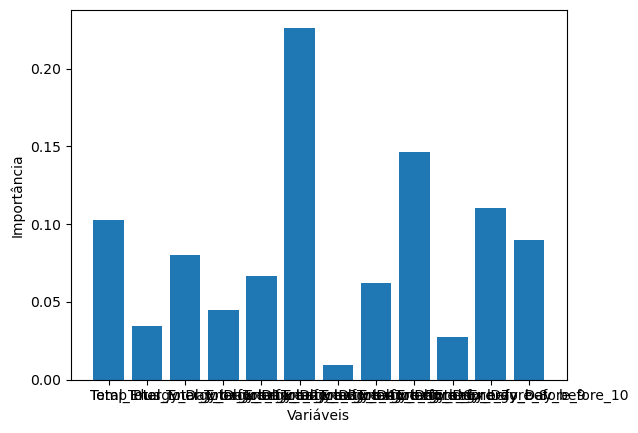

Mean Squared Error: 340.47721435510294
R-squared (R2): -0.6716798544843343

     Temp  Plus  Total_Energy_Day_before_1  Total_Energy_Day_before_2  \
50  12.25  0.00                      42.08                      32.55   
30  15.25  0.03                      21.77                      20.49   
18  20.50  0.00                      55.15                      48.61   
23  17.25  0.30                      34.56                      41.41   
59  14.25  0.10                      48.04                      42.31   
54  10.50  0.00                      41.44                      31.92   
75  20.00  0.00                      53.18                      53.17   
19  18.00  0.13                      32.25                      55.15   
78  18.00  0.00                      25.98                      47.33   
26  18.25  2.13                      40.43                      39.86   
39  14.00  0.20                      50.26                      54.07   
73  14.75  0.00                      17.95      

In [50]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import tree


# Features e TARGET_VARIABLE
#feature_columns = ['Temp', 'Plus'] + [f'Total_Energy_Day_before_{i}' for i in range(1, 11)]
#X = summed_days[feature_columns]
# Features e TARGET_VARIABLE
X = summed_days[[ 'Temp', 'Total_Energy_Day_before_1','Total_Energy_Day_before_2']]
y = summed_days['Total Energy (kWh)']

# Divisão do dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicialização e treino  Gradient Boosting
model = GradientBoostingRegressor(n_estimators=30, learning_rate=0.1, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# Obter a importância das características
importancia_caracteristicas = model.feature_importances_

# Exibir a importância das características
for nome_variavel, importancia in zip(X.columns, importancia_caracteristicas):
    print(f'{nome_variavel}: {importancia}')

# Exibir um gráfico de barras para visualizar a importância das características
plt.bar(X.columns.astype(str), importancia_caracteristicas)
plt.xlabel('Variáveis')
plt.ylabel('Importância')
plt.show()

# Fazer previsões no conjunto de teste
predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f'Mean Squared Error: {mse}')
print(f'R-squared (R2): {r2}')
print()
print(X_test)
print(predictions)

[[ 0.    0.    0.  ]
 [ 0.    0.    0.  ]
 [ 0.    0.    0.  ]
 ...
 [ 0.    0.    0.  ]
 [17.    0.    0.  ]
 [18.   45.13  0.  ]]
[ 0.     0.     0.     0.    59.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.    30.419 45.87
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.    40.61   0.    36.51   0.    40.99   0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.    41.17   0.     0.
  0.     0.    32.42   0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.    27.25
  0.     0.     0.    22.74  66.36   0.     0.    29.2   36.38   0.
  0.     0.     0.     0.    23.43   0.     0.     0.     0.     0.
 42.59   0.     0.     0.     0.    48.61   0.    55.15  32.25   0.
  0.    20.02   0.     0.    76.71   0.     0.  

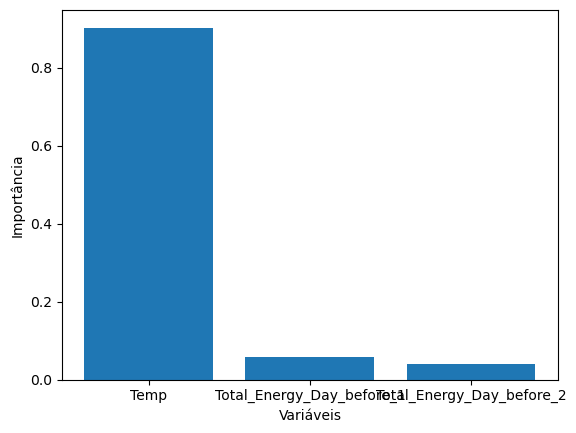

Mean Squared Error: 27.288529779190362
R-squared (R2): 0.8748176986656988



In [48]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import tree


# Features e TARGET_VARIABLE
X = merged_data[[ 'Temp', 'Total_Energy_Day_before_1','Total_Energy_Day_before_2']]
y = merged_data['Total Energy (kWh)']


print(X.values)
print(y.values)
"""crossvalidation=KFold(n_splits=10,shuffle=True,random_state=1)

for depth in range(1, 10):
    tree_regressor = tree.DecisionTreeRegressor(max_depth=depth, random_state=1)
    if tree_regressor.fit(X, y).tree_.max_depth < depth:
        break
    score = np.mean(cross_val_score(tree_regressor, X, y, scoring='neg_mean_squared_error', cv=crossvalidation, n_jobs=1))
    print(depth, score)


GBR=GradientBoostingRegressor()
search_grid={'n_estimators':[500,1000,2000],'learning_rate':[.001,0.01,.1],'max_depth':[1,2,4],'subsample':[.5,.75,1],'random_state':[1]}
search=GridSearchCV(estimator=GBR,param_grid=search_grid,scoring='neg_mean_squared_error',n_jobs=1,cv=crossvalidation)

search.fit(X,y)
search.best_params_
"""
# Divisão do dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicialização e treino  Gradient Boosting
model = GradientBoostingRegressor(n_estimators=30, learning_rate=0.1, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# Obter a importância das características
importancia_caracteristicas = model.feature_importances_

# Exibir a importância das características
for nome_variavel, importancia in zip(X.columns, importancia_caracteristicas):
    print(f'{nome_variavel}: {importancia}')

# Exibir um gráfico de barras para visualizar a importância das características
plt.bar(X.columns.astype(str), importancia_caracteristicas)
plt.xlabel('Variáveis')
plt.ylabel('Importância')
plt.show()

# Fazer previsões no conjunto de teste
predictions = model.predict(X_test)

# Avali# Fazer previsões no conjunto de teste
#predictions = pd.Series(model.predict(X_test), index=X_test['Start date'])  # Set the index to 'Day of Week'ação do desempenho do modelo
# Fazer previsões no conjunto de teste
#predictions = pd.Series(model.predict(X_test), index=X_test.index)

mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f'Mean Squared Error: {mse}')
print(f'R-squared (R2): {r2}')
print()

# Visualização das previsões em comparação com os valores reais
#print(predictions)

Temp: 0.9567823952911595
Plus: 0.04321760470884051


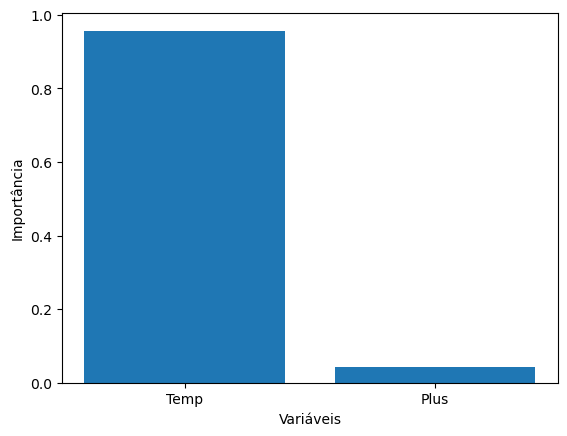

Mean Squared Error: 96.31839290176516
R-squared (R2): 0.7118731616560798



In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import tree


# Features e TARGET_VARIABLE
X = merged_data[[ 'Temp', 'Plus']]
y = merged_data['Total Energy (kWh)']

# Divisão do dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicialização e treino  Gradient Boosting
model = GradientBoostingRegressor(n_estimators=30, learning_rate=0.1, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# Obter a importância das características
importancia_caracteristicas = model.feature_importances_

# Exibir a importância das características
for nome_variavel, importancia in zip(X.columns, importancia_caracteristicas):
    print(f'{nome_variavel}: {importancia}')

# Exibir um gráfico de barras para visualizar a importância das características
plt.bar(X.columns.astype(str), importancia_caracteristicas)
plt.xlabel('Variáveis')
plt.ylabel('Importância')
plt.show()

# Fazer previsões no conjunto de teste
predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f'Mean Squared Error: {mse}')
print(f'R-squared (R2): {r2}')
print()
#print(X_test)
#print(predictions)

In [25]:
#file = pd.read_csv('resultado_Data_merged_29.csv.csv')
file = pd.read_csv('resultado_Data_merged_55.csv.csv')

file = file.drop(columns=['Nº cartão EVIO', 'Temp', 'Plus', 'Duration (min)'])

file['Total_Energy_Day_before_7'] = file['Total Energy (kWh)'].shift(7)
file['Total_Energy_Day_before_1'] = file['Total Energy (kWh)'].shift(1)

# Remover as linhas com valores NaN resultantes do deslocamento
file = file.dropna()

file['date'] = pd.to_datetime(file['date'], format='%Y-%m-%d %H:%M')
# Adicione a coluna 'Day of Week'
file['Day of Week'] = file['date'].dt.day_name()
day_of_week_mapping = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
file['Day of Week'] = file['Day of Week'].map(day_of_week_mapping)

print(file.head)

<bound method NDFrame.head of           date  Total Energy (kWh)  Total_Energy_Day_before_7  \
7   2023-02-15                8.90                      12.52   
8   2023-02-16               12.41                      12.39   
9   2023-02-17               14.67                       9.30   
10  2023-02-18                0.00                       0.00   
11  2023-02-19                0.00                       0.00   
..         ...                 ...                        ...   
367 2024-02-10                0.00                       0.00   
368 2024-02-11                0.00                       0.00   
369 2024-02-12                0.00                       0.00   
370 2024-02-13                0.00                      23.13   
371 2024-02-14               12.25                       5.90   

     Total_Energy_Day_before_1  Day of Week  
7                       12.403            3  
8                        8.900            4  
9                       12.410            5  
10   

In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import tree


# Features e TARGET_VARIABLE
X = file[['Total_Energy_Day_before_7', 'Day of Week','Total_Energy_Day_before_1']]
y = file['Total Energy (kWh)']

# Divisão do dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'Random Forest': RandomForestRegressor(),
    'XGBoost': XGBRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Linear Regression': LinearRegression()
}

# Loop through each model
for model_name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)

    # Make predictions
    predictions = model.predict(X_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    # Print metrics
    print(f"Model: {model_name}")
    print(f'Mean Squared Error: {mse}')
    print(f'R-squared (R2): {r2}')
    print()

Model: Random Forest
Mean Squared Error: 52.63822640723544
R-squared (R2): 0.1369425708812585

Model: XGBoost
Mean Squared Error: 78.00005127750313
R-squared (R2): -0.2788904247244648

Model: Gradient Boosting
Mean Squared Error: 53.651520031405504
R-squared (R2): 0.12032858804200353

Model: Linear Regression
Mean Squared Error: 51.41444318173965
R-squared (R2): 0.1570077454983474



In [29]:
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Features e TARGET_VARIABLE
X = file[['Total_Energy_Day_before_7', 'Day of Week','Total_Energy_Day_before_1']]
y = file['Total Energy (kWh)']

# Divisão do conjunto de dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalização dos dados (é uma boa prática para redes neurais)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Construção do modelo de rede neural
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # Camada de saída para uma tarefa de regressão
])

# Compilação do modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinamento do modelo
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=2)

# previsões no conjunto de teste
predictions = model.predict(X_test_scaled).flatten()

# Avaliação do desempenho do modelo
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')
r2 = r2_score(y_test, predictions)
print(f'R-squared (R2): {r2}')
print(predictions)

Epoch 1/100
8/8 - 1s - loss: 82.5753 - val_loss: 70.3245 - 770ms/epoch - 96ms/step
Epoch 2/100
8/8 - 0s - loss: 78.2908 - val_loss: 65.8985 - 44ms/epoch - 5ms/step
Epoch 3/100
8/8 - 0s - loss: 73.7313 - val_loss: 61.6826 - 48ms/epoch - 6ms/step
Epoch 4/100
8/8 - 0s - loss: 69.3599 - val_loss: 57.3785 - 45ms/epoch - 6ms/step
Epoch 5/100
8/8 - 0s - loss: 64.4366 - val_loss: 53.8406 - 54ms/epoch - 7ms/step
Epoch 6/100
8/8 - 0s - loss: 59.8151 - val_loss: 51.5530 - 49ms/epoch - 6ms/step
Epoch 7/100
8/8 - 0s - loss: 56.2504 - val_loss: 51.1172 - 48ms/epoch - 6ms/step
Epoch 8/100
8/8 - 0s - loss: 55.0094 - val_loss: 52.1328 - 49ms/epoch - 6ms/step
Epoch 9/100
8/8 - 0s - loss: 53.8210 - val_loss: 52.7681 - 55ms/epoch - 7ms/step
Epoch 10/100
8/8 - 0s - loss: 53.3994 - val_loss: 53.0185 - 39ms/epoch - 5ms/step
Epoch 11/100
8/8 - 0s - loss: 53.0697 - val_loss: 52.1497 - 52ms/epoch - 6ms/step
Epoch 12/100
8/8 - 0s - loss: 52.6803 - val_loss: 52.0760 - 52ms/epoch - 6ms/step
Epoch 13/100
8/8 - 0s -

Mean Squared Error: 52.22985896452971
R-squared (R2): 0.14363817176474403
[-0.68521255  6.8281074   7.505201    6.7256427   6.595802    7.5150857
  7.1793094   7.491945    7.716357    8.459538    7.0997057  -0.68521255
  0.4706016   7.5101714  -0.68521255  9.619342    7.719603    5.9439797
  7.5560355   0.4399465   5.4393234  -0.68521255  6.581055    7.2491245
  2.6272128   7.8487124   0.49114606  8.121337    4.144462   -0.68521255
 -0.68521315  2.627213    7.2620206   6.801927    7.5713377   6.801927
  7.5080643   7.5009394   7.9256063   0.07311388 -0.68521255  6.801927
  6.8807817   2.6272128  -0.68521255  2.6272128   7.1793094   7.555885
  6.8281074   0.42833444  6.801927    2.6272128   0.44787386  2.6272128
  7.87085     4.233003    3.7883594   0.39676479  6.801927    7.2620206
  7.1793094  -0.68521255  7.595084   -0.68521315  7.5237827   2.6272128
  7.2620206   8.121337    7.4643445   6.8281074   0.9461903   2.6272128
  2.6272128 ]


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tpot import TPOTRegressor

# Features e TARGET_VARIABLE
X = subset_data[['Temp', 'Plus']]
y = subset_data['Total Energy (kWh)']

# Divisão do dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicialização do AutoML TPOT
tpot = TPOTRegressor(generations=5, population_size=50, verbosity=2, random_state=42)

# Treino do modelo AutoML TPOT
tpot.fit(X_train, y_train)

# Avaliação do modelo AutoML TPOT
mse = tpot.score(X_test, y_test)
print('Erro quadrático médio do modelo AutoML TPOT:', mse)

# Exportar o pipeline final
tpot.export('tpot_pipeline.py')

ImportError: cannot import name '_fit_context' from 'sklearn.base' (C:\Users\miguel.preto\Anaconda3\lib\site-packages\sklearn\base.py)

In [17]:
pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [15]:
pip install tpot

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached joblib-1.3.2-py3-none-any.whl.metadata (5.4 kB)
   ---------------------------------------- 87.4/87.4 kB 126.8 kB/s eta 0:00:00
   ---------------------------------------- 109.9/109.9 kB 2.1 MB/s eta 0:00:00
   ---------------------------------------- 10.6/10.6 MB 6.7 MB/s eta 0:00:00
Using cached joblib-1.3.2-py3-none-any.whl (302 kB)
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11939 sha256=a007e4b4caab0b17e97d570aa53ead70b168742c9e07e580e87bd831db792f83
  Stored in directory: c:\users\miguel.preto\appdata\local\pip\cache\wheels\48\8c\93\3afb1916772591fe6bcc25cdf8b1c5bdc362f0ec8e2f0fd413
Successfully built stopit
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-lear

  You can safely remove it manually.


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import autokeras as ak

# Features e TARGET_VARIABLE
X = subset_data[['Temp', 'Plus']]
y = subset_data['Total Energy (kWh)']

# Divisão do dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicialização do AutoML
auto_model = ak.StructuredDataRegressor(max_trials=10)  # número máximo de tentativas

# Treino do modelo AutoML
auto_model.fit(X_train, y_train, epochs=10)

# Avaliação do modelo AutoML
mse = auto_model.evaluate(X_test, y_test)
print('Erro quadrático médio do modelo AutoML:', mse)

# Fazer previsões no conjunto de teste
predictions = auto_model.predict(X_test)
print(predictions)

ModuleNotFoundError: No module named 'autokeras'

In [10]:
!pip install autokeras

  Using cached autokeras-2.0.0-py3-none-any.whl (122 kB)
  Using cached keras_tuner-1.4.7-py3-none-any.whl (129 kB)
  Using cached dm_tree-0.1.8-cp39-cp39-win_amd64.whl (101 kB)
  Using cached keras_nlp-0.8.2-py3-none-any.whl (465 kB)
  Using cached keras-3.1.1-py3-none-any.whl (1.1 MB)
  Using cached optree-0.11.0-cp39-cp39-win_amd64.whl (240 kB)
  Using cached rich-13.7.1-py3-none-any.whl (240 kB)
  Using cached namex-0.0.7-py3-none-any.whl (5.8 kB)
  Using cached tensorflow_text-2.10.0-cp39-cp39-win_amd64.whl (5.0 MB)
  Using cached kagglehub-0.2.2-py3-none-any.whl (32 kB)
  Using cached keras_core-0.1.7-py3-none-any.whl (950 kB)
  Using cached kt_legacy-1.0.5-py3-none-any.whl (9.6 kB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl (87 kB)
  Using cached pygments-2.17.2-py3-none-any.whl (1.2 MB)
  Using cached tensorflow-2.10.1-cp39-cp39-win_amd64.whl (455.9 MB)
  Using cached tensorflow_hub-0.16.1-py2.py3-none-any.whl (30 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl (10.0 

  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [12 lines of output]
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
    File "C:\Users\miguel.preto\AppData\Local\Temp\pip-install-atrhwojj\requests_9943ee1af31c48a981671a41fe51b62b\setup.py", line 6, in <module>
      import requests
    File "C:\Users\miguel.preto\AppData\Local\Temp\pip-install-atrhwojj\requests_9943ee1af31c48a981671a41fe51b62b\requests\__init__.py", line 52, in <module>
      from . import utils
    File "C:\Users\miguel.preto\AppData\Local\Temp\pip-install-atrhwojj\requests_9943ee1af31c48a981671a41fe51b62b\requests\utils.py", line 22, in <module>
      from .compat import parse_http_list as _parse_list_header
    File "C:\Users\miguel.preto\AppData\Local\Temp\pip-install-atrhwojj\requests_9943ee1af31c48a981671a41fe51b62b\requests\compat.py", line 112, in <module>
   

In [10]:
pip cache purge

Files removed: 669
Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install --upgrade pip setuptools

     ---------------------------------------- 2.1/2.1 MB 16.8 MB/s eta 0:00:00
     ------------------------------------- 821.5/821.5 kB 26.2 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 63.4.1
    Uninstalling setuptools-63.4.1:
      Successfully uninstalled setuptools-63.4.1
  Attempting uninstall: pip
    Found existing installation: pip 22.2.2
    Uninstalling pip-22.2.2:
      Successfully uninstalled pip-22.2.2
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 5.2.2 requires pyqt5<5.13, which is not installed.
spyder 5.2.2 requires pyqtwebengine<5.13, which is not installed.
anaconda-project 0.11.1 requires ruamel-yaml, which is not installed.
tensorflow-intel 2.15.0 requires flatbuffers>=23.5.26, but you have flatbuffers 2.0.7 which is incompatible.
tensorflow-intel 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 2.8.0 which is incompatible.
tensorflow-intel 2.15.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.20.0 which is incompatible.
tensorflow-intel 2.15.0 requires tensorboard<2.16,>=2.15, but you have tensorboard 2.8.0 which is incompatible.
tensorflow-intel 2.15.0 requires tensorflow-estimator<2.16,>=2.15.0, but you have tensorflow-estimator 2.7.0 which is incompatible.
numba 0.5

In [12]:
pip install requests==2.31.0

  Using cached requests-2.31.0-py3-none-any.whl.metadata (4.6 kB)
Using cached requests-2.31.0-py3-none-any.whl (62 kB)
  Attempting uninstall: requests
    Found existing installation: requests 2.28.1
    Uninstalling requests-2.28.1:
      Successfully uninstalled requests-2.28.1
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anaconda-project 0.11.1 requires ruamel-yaml, which is not installed.
spyder 5.2.2 requires pyqt5<5.13, which is not installed.
spyder 5.2.2 requires pyqtwebengine<5.13, which is not installed.
tensorflow-intel 2.15.0 requires flatbuffers>=23.5.26, but you have flatbuffers 2.0.7 which is incompatible.
tensorflow-intel 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 2.8.0 which is incompatible.
tensorflow-intel 2.15.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.20.0 which is incompatible.
tensorflow-intel 2.15.0 requires tensorboard<2.16,>=2.15, but you have tensorboard 2.8.0 which is incompatible.
tensorflow-intel 2.15.0 requires tensorflow-estimator<2.16,>=2.15.0, but you have tensorflow-estimator 2.7.0 which is incompatible.
conda-rep

In [12]:
from xgboost import XGBRegressor

n_estimators = [ 30, 40, 50, 60, 80, 90, 100]
learning_rate = [0.1, 0.2, 0.3]
max_depth = [ 1,2,3,4,5 ,6, 7, 8]
random_state = [42, 43, 45]

clf = GridSearchCV(GradientBoostingRegressor(), {
        'n_estimators': n_estimators,
        'learning_rate': learning_rate,
        'max_depth': max_depth,
        'random_state': random_state,
    },
    cv=5,
    return_train_score=False
)

clf.fit(X, y)
clf_results = pd.DataFrame(clf.cv_results_)
print("Best Params:", clf.best_params_)

clf_results.sort_values(by="rank_test_score", inplace=True)
clf_results[['random_state','param_learning_rate', 'param_max_depth', 'param_n_estimators', 'params', 'rank_test_score']]

Best Params: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 40, 'random_state': 42}


KeyError: "['random_state'] not in index"

In [ ]:
# Initialize models
models = {
    'Random Forest': RandomForestRegressor(),
    'LGBM': LGBMRegressor(),
    'XGBoost': XGBRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Linear Regression': LinearRegression()
}

# Dictionary to store regression metrics
metrics = {
    'Model': [],
    'MSE': [],
    'MAE': [],
    'MAPE': [],
    'SMAPE': []
}

# Evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    smape = (np.mean(2 * np.abs(y_test -  y_pred) / (np.abs(y_test) + np.abs(y_pred))))*100

    metrics['Model'].append(model_name)
    metrics['MSE'].append(mse)
    metrics['MAE'].append(mae)
    metrics['MAPE'].append(mape)
    metrics['SMAPE'].append(smape)

# Create a DataFrame to display the metrics
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

In [6]:
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


# Features e TARGET_VARIABLE
X = merged_data[[ 'Temp', 'Plus', 'Day of Week', 'Month']]
y = merged_data['Total Energy (kWh)']

# Divisão do conjunto de dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalização dos dados (é uma boa prática para redes neurais)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Construção do modelo de rede neural
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # Camada de saída para uma tarefa de regressão
])

# Compilação do modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinamento do modelo
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=2)

# previsões no conjunto de teste
predictions = model.predict(X_test_scaled).flatten()

# Avaliação do desempenho do modelo
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')
r2 = r2_score(y_test, predictions)
print(f'R-squared (R2): {r2}')
print(predictions)

Epoch 1/100
8/8 - 1s - loss: 380.3422 - val_loss: 235.3041 - 904ms/epoch - 113ms/step
Epoch 2/100
8/8 - 0s - loss: 363.7895 - val_loss: 224.0564 - 68ms/epoch - 9ms/step
Epoch 3/100
8/8 - 0s - loss: 347.4422 - val_loss: 211.2448 - 73ms/epoch - 9ms/step
Epoch 4/100
8/8 - 0s - loss: 329.1226 - val_loss: 196.5266 - 58ms/epoch - 7ms/step
Epoch 5/100
8/8 - 0s - loss: 306.0032 - val_loss: 179.2591 - 61ms/epoch - 8ms/step
Epoch 6/100
8/8 - 0s - loss: 281.5625 - val_loss: 159.3795 - 65ms/epoch - 8ms/step
Epoch 7/100
8/8 - 0s - loss: 252.7937 - val_loss: 135.7379 - 61ms/epoch - 8ms/step
Epoch 8/100
8/8 - 0s - loss: 218.8169 - val_loss: 112.2129 - 53ms/epoch - 7ms/step
Epoch 9/100
8/8 - 0s - loss: 185.6784 - val_loss: 89.1987 - 59ms/epoch - 7ms/step
Epoch 10/100
8/8 - 0s - loss: 154.4484 - val_loss: 68.2955 - 57ms/epoch - 7ms/step
Epoch 11/100
8/8 - 0s - loss: 124.4335 - val_loss: 51.7909 - 57ms/epoch - 7ms/step
Epoch 12/100
8/8 - 0s - loss: 103.8037 - val_loss: 39.6109 - 58ms/epoch - 7ms/step
Ep

Mean Squared Error: 74.48864877832752
R-squared (R2): 0.7771746577323042
[ 4.1858912e-01  3.9682167e+01 -2.6155329e-01  3.9631428e+01
 -1.7871256e-01 -4.4971600e-02  1.3852613e-01  4.4511395e+01
 -3.0577493e-01 -3.0311489e-01 -1.2800808e-01  4.4974876e+01
  3.6502773e+01 -2.5096375e-01  3.8979748e+01  9.0463609e-03
  3.0186733e+01 -1.4967576e-02  8.5117325e-02 -2.3559476e-01
  3.2200066e+01 -3.1521773e-01  4.1545685e+01 -2.2870268e-01
 -4.5335698e-01  4.2415451e+01  1.7839788e-01 -4.0550959e-01
  4.3667406e-03  2.9453501e-02  4.1923374e-03  1.2715153e-01
 -1.4034225e-01  2.9021057e+01 -1.6412409e-01  4.3667406e-03
  1.3852613e-01 -1.0047689e-02  1.7496005e-02 -2.1608621e-03
 -1.5055181e-01  2.3208536e-01 -2.6335597e-01  4.2378086e+01
 -2.4842575e-02  5.3472114e-01  4.4772163e+01 -2.3567547e-01
  9.4533727e-02 -2.3559476e-01  3.4335045e+01  3.0250681e+01
  1.9665144e-01 -2.0934553e-01 -1.4034225e-01  4.1007832e+01
  5.5045351e-02 -3.7777320e-02  4.0949532e+01 -3.1607199e-01
 -1.7871256e

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Features e TARGET_VARIABLE
X = merged_data[[ 'Temp', 'Plus', 'Day of Week', 'Month']]
y = merged_data['Total Energy (kWh)']

# Divisão do conjunto de dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicialização e treino do modelo KNN para regressão
knn_model = KNeighborsRegressor(n_neighbors=5)  # Você pode ajustar o número de vizinhos conforme necessário
knn_model.fit(X_train, y_train)

# Previsões no conjunto de teste
predictions = knn_model.predict(X_test)

# Avaliação do modelo
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R2): {r2}')
print(predictions)

Mean Squared Error (MSE): 82.5658890477778
R-squared (R2): 0.753012401373288
[ 0.     46.826   0.     38.458   0.      0.      0.     48.284   0.
  0.      0.     29.69   41.02    0.     37.882   0.     35.156   0.
  0.      0.     30.758   0.     32.466   0.      0.     36.122   0.
  0.      0.      0.      0.      0.      0.     30.58    0.      0.
  0.      0.      0.      0.      0.      0.      0.     43.916   0.
  0.     48.26    0.      0.      0.     27.1862 40.272   0.      0.
  0.     47.702   0.      0.     48.26    0.      0.      0.     32.802
  0.      0.      0.      0.      0.      0.     46.748   0.     21.204 ]


In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Features e TARGET_VARIABLE
X = merged_data[['Power', 'Temp', 'Plus', 'Day of Week', 'Month']]
y = merged_data['Total Energy (kWh)']

# Divisão do dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicialização e treino  Gradient Boosting
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Criar um DataFrame com os dias da semana de teste e fazer as previsões
predictions_dates = pd.DataFrame({'Day of Week': X_test['Day of Week'], 'Predictions': model.predict(X_test)})

# Avaliação do desempenho do modelo
mse = mean_squared_error(y_test, predictions_dates['Predictions'])
r2 = r2_score(y_test, predictions_dates['Predictions'])
print(f'Mean Squared Error: {mse}')
print(f'R-squared (R2): {r2}')
print()

# Visualização das previsões em comparação com os valores reais
print(predictions_dates)

Mean Squared Error: 54.27712309823986
R-squared (R2): 0.8376354151937577
     Day of Week  Predictions
224            2     0.037315
42             2    40.842204
285            7     0.022330
302            3    29.562032
56             2     0.037315
..           ...          ...
199            5     0.022330
333            6     0.022330
93             4    38.333548
198            4     0.037315
197            3    43.734852

[72 rows x 2 columns]


In [5]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Normalização dos dados
scaler = StandardScaler()
X_kmeans = scaler.fit_transform(merged_data)

# Escolha do número de clusters 
num_clusters = 5

# Aplicação do K-Means
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
merged_data['Cluster'] = kmeans.fit_predict(X_kmeans)

# Obter estatísticas descritivas para cada cluster
cluster_stats = merged_data.groupby('Cluster')['Total Energy (kWh)'].describe()
print(cluster_stats)

# Crie um boxplot para visualizar a distribuição da energia em cada cluster
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Total Energy (kWh)', data=merged_data)
plt.title('Distribuição da Energia em Cada Cluster')
plt.show()

DTypePromotionError: The DType <class 'numpy.dtypes.DateTime64DType'> could not be promoted by <class 'numpy.dtypes.Float64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>)

In [6]:
# Defina os quantis desejados 
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]

# Agrupa por 'Cluster' e calcula os quantis para a coluna de energia
quantiles_by_cluster = EV.groupby('Cluster')['Total Energy (kWh)'].quantile(quantiles).unstack()

# Visualiza os quantis para cada cluster
#print(quantiles_by_cluster)
print()

# Calcula a distribuição percentual dos clusters para cada dia da semana
cluster_distribution = EV.groupby('Day of Week')['Cluster'].value_counts(normalize=True).unstack() * 100

# Visualiza a distribuição percentual dos clusters para cada dia da semana
#print(cluster_distribution)
print()

# Substitui todos os valores NaN por zero na tabela cluster_distribution
cluster_distribution = cluster_distribution.fillna(0)

# Imprime a nova tabela com NaNs substituídos por zero
#print(cluster_distribution)
#print()

# Inicializa um DataFrame para armazenar os resultados
weighted_quantiles = pd.DataFrame(index=cluster_distribution.index, columns=quantiles)

# Calcula a soma ponderada dos quantis para cada dia da semana
for quantile in quantiles:
    for cluster in cluster_distribution.columns:
        weighted_quantiles[quantile] = weighted_quantiles[quantile].fillna(0) + (cluster_distribution[cluster] / 100) * quantiles_by_cluster.loc[cluster, quantile]

# Imprime o DataFrame com as somas ponderadas dos quantis
#print(weighted_quantiles)

# Adiciona as colunas dos quantis ao DataFrame X
EV = pd.merge(EV, weighted_quantiles, left_on='Day of Week', right_index=True, suffixes=('', '_Quantile'))
print(EV)

KeyError: 'Cluster'

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


# Features e TARGET_VARIABLE
X = EV[['Temp', 'Plus','Day of Week', 'Season', 'Month', 'Período Escolar', 0.05, 0.25, 0.5, 0.75, 0.95]]
print(X)
y = EV['Total Energy (kWh)'] 

# Divisão do conjunto de dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicialização e treino modelo de Gradient Boosting
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Obtenha a importância das características
importancia_caracteristicas = model.feature_importances_

# Exiba a importância das características
for nome_variavel, importancia in zip(X.columns, importancia_caracteristicas):
    print(f'{nome_variavel}: {importancia}')

# Exiba um gráfico de barras para visualizar a importância das características
plt.bar(X.columns.astype(str), importancia_caracteristicas)
plt.xlabel('Variáveis')
plt.ylabel('Importância')
plt.show()

# Fazendo previsões no conjunto de teste
predictions = model.predict(X_test)

# Avaliação do desempenho do modelo
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f'Mean Squared Error: {mse}')
print(f'R-squared (R2): {r2}')

# Visualização das previsões em comparação com os valores reais
print(predictions)